In [1]:
import numpy as np
import pandas as pd
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import matplotlib.pyplot as plt

from sys import path as pylib #im naming it as pylib so that we won't get confused between os.path and sys.path 
import os
pylib += [os.path.abspath(r'/home/Jay/Notebooks/Group9_emotion_detection/torchMoji')]

In [2]:
data = pd.read_csv('../../deepmoji/data/train.txt', sep = '\t')

In [3]:
label2emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion2label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

emoticons_additional = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter",
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter",
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_additional]
)


def tokenize(text):
    text = " ".join(text_processor.pre_process_doc(text))
    return text

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


### Load raw data

In [5]:
x=[]
y=[]

for ind, row in data.iterrows():
    y.append(emotion2label[row['label']])
    x.append(tokenize(row['turn1'])+' <eos> '+tokenize(row['turn2']) + ' <eos> '+tokenize(row['turn3']))

In [6]:
test_data = pd.read_csv('../../deepmoji/data/test.txt', sep = '\t')
test_x = []
test_y=[]

for ind, row in test_data.iterrows():
    test_y.append(emotion2label[row['label']])
    test_x.append(tokenize(row['turn1'])+' <eos> '+tokenize(row['turn2']) + ' <eos> '+tokenize(row['turn3']))

In [7]:
from __future__ import print_function, division, unicode_literals
import json

from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.model_def import torchmoji_emojis
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

def encode_deepmoji(x):
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    model = torchmoji_feature_encoding(PRETRAINED_PATH)
    print(model)
    print('Encoding texts..')
    encoding = np.zeros((len(x), 2304))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

def encode_emoji(x):
    model = torchmoji_emojis(PRETRAINED_PATH)
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    print(model)
    print('Running predictions.')
    
    encoding = np.zeros((len(x), 64))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

### Create vectors

In [10]:
x_vec = encode_deepmoji(x)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights 

In [11]:
test_x_vec = encode_deepmoji(test_x)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights 

In [20]:
np.save('../../dm_emb/deepmoji_train_x.npy', x_vec)

In [21]:
np.save('../../dm_emb/deepmoji_test_x.npy', test_x_vec)

### Load saved vectors

In [8]:
x_vec = np.load('../../dm_emb/deepmoji_train_x.npy')
test_x_vec = np.load('../../dm_emb/deepmoji_test_x.npy')

In [9]:
print(x_vec.shape)
print(test_x_vec.shape)

(30160, 2304)
(5509, 2304)


In [10]:
emoji_all = encode_emoji(x)
emoji_test = encode_emoji(test_x)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)
Running predictions.


/home/Jay/dev32/lib/python3.5/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)
Running predictions.


In [11]:
tokens = [v for k,v in label2emotion.items()]
tokens

['others', 'happy', 'sad', 'angry']

In [12]:
y=np.array(y)
idx_others=np.where(y==0)[0]

In [13]:
idx = np.r_[np.random.choice(idx_others,6000),np.where(y==1)[0],np.where(y==2)[0],np.where(y==3)[0]]

In [14]:
idx.shape

(21212,)

In [15]:
deepmoji_train = x_vec[idx]
y_train = y[idx]
emoji_train = emoji_all[idx]

In [16]:
deepmoji_test = test_x_vec

### Models

In [17]:
from sklearn import metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import itertools
from sklearn.linear_model import LogisticRegression

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def print_metrics(mc_prediction):
    print(metrics.classification_report(test_y, mc_prediction, target_names=tokens))
    print("Accuracy:", metrics.accuracy_score(test_y, mc_prediction))
    print("Precision:", metrics.precision_score(test_y, mc_prediction, average='macro'))
    print("Recall:", metrics.recall_score(test_y, mc_prediction, average='macro'))
    print("F1 score: ", metrics.f1_score(test_y, mc_prediction, average='macro'))
    #print("Confusion Matrix: \n", metrics.confusion_matrix(mc_Y_test, mc_prediction))
    plot_confusion_matrix(metrics.confusion_matrix(test_y, mc_prediction), tokens)

### Logistic Regression

In [19]:
LR = Pipeline([('scaler', MinMaxScaler()), ('clf', LogisticRegression(random_state=0))])
#LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

             precision    recall  f1-score   support

     others       0.97      0.78      0.86      4677
      happy       0.32      0.71      0.44       284
        sad       0.36      0.70      0.48       250
      angry       0.40      0.84      0.54       298

avg / total       0.88      0.78      0.81      5509

Accuracy: 0.7750952986022872
Precision: 0.5109707182568828
Recall: 0.7556656707792635
F1 score:  0.5792467368269634
Confusion matrix, without normalization
[[3645  404  280  348]
 [  56  201   16   11]
 [  41   13  175   21]
 [  24   10   15  249]]


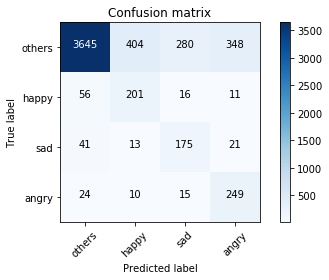

In [20]:
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

     others       0.97      0.78      0.86      4677
      happy       0.32      0.69      0.44       284
        sad       0.37      0.72      0.49       250
      angry       0.38      0.83      0.52       298

avg / total       0.87      0.77      0.80      5509

Accuracy: 0.7723724813940824
Precision: 0.5092153701925783
Recall: 0.7545572748893179
F1 score:  0.5771612264842599
Confusion matrix, without normalization
[[3631  398  270  378]
 [  61  197   16   10]
 [  37   12  179   22]
 [  27    8   15  248]]


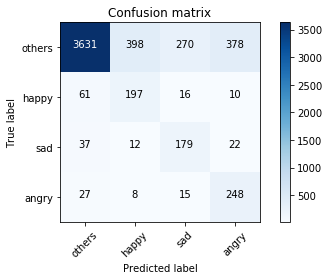

In [21]:
LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

     others       0.95      0.89      0.92      4677
      happy       0.45      0.52      0.48       284
        sad       0.51      0.64      0.57       250
      angry       0.51      0.78      0.62       298

avg / total       0.88      0.86      0.87      5509

Accuracy: 0.8571428571428571
Precision: 0.6050265191526082
Recall: 0.7092387669683302
F1 score:  0.6473441923387087
Confusion matrix, without normalization
[[4181  169  130  197]
 [ 117  148   10    9]
 [  64    8  160   18]
 [  49    3   13  233]]


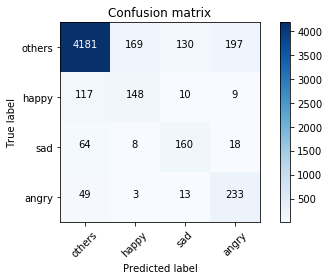

In [22]:
LR = LogisticRegression(random_state=0).fit(x_vec, y) 
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

     others       0.91      0.71      0.80      4677
      happy       0.17      0.37      0.24       284
        sad       0.26      0.52      0.35       250
      angry       0.26      0.66      0.37       298

avg / total       0.81      0.68      0.73      5509

Accuracy: 0.6819749500816845
Precision: 0.4013201479591903
Recall: 0.5671615056640446
F1 score:  0.4386253142077552
Confusion matrix, without normalization
[[3323  485  346  523]
 [ 158  105    8   13]
 [  80    8  131   31]
 [  72    4   24  198]]


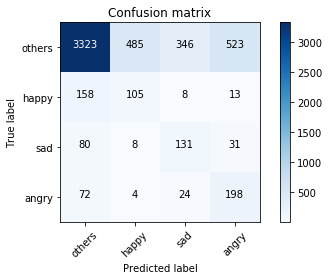

In [23]:
LR = LogisticRegression(random_state=0).fit(emoji_train, y_train) 
print_metrics(LR.predict(emoji_test))

             precision    recall  f1-score   support

     others       0.89      0.94      0.91      4677
      happy       0.30      0.04      0.06       284
        sad       0.42      0.38      0.40       250
      angry       0.46      0.47      0.46       298

avg / total       0.81      0.84      0.82      5509

Accuracy: 0.840624432746415
Precision: 0.515931836645843
Recall: 0.4539656184448747
F1 score:  0.45797271479770607
Confusion matrix, without normalization
[[4388   23  117  149]
 [ 269   10    1    4]
 [ 143    0   94   13]
 [ 146    0   13  139]]


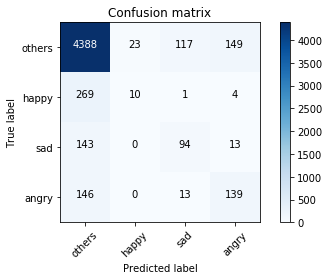

In [24]:
LR = LogisticRegression(random_state=0).fit(emoji_all, y) 
print_metrics(LR.predict(emoji_test))

### Naive Bayes

             precision    recall  f1-score   support

     others       0.93      0.76      0.83      4677
      happy       0.29      0.53      0.37       284
        sad       0.38      0.53      0.44       250
      angry       0.26      0.73      0.39       298

avg / total       0.84      0.73      0.77      5509

Accuracy: 0.7333454347431476
Precision: 0.46404010582439725
Recall: 0.6363130948365457
F1 score:  0.5081718690343512
Confusion matrix, without normalization
[[3540  366  204  567]
 [ 112  150    7   15]
 [  80    7  133   30]
 [  71    2    8  217]]


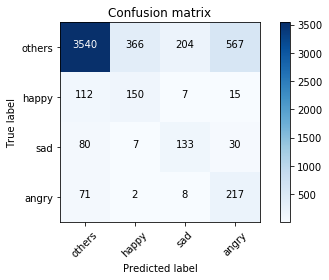

In [25]:
mc_nb = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
mc_nb.fit(deepmoji_train, y_train)
print_metrics(mc_nb.predict(deepmoji_test))

/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

     others       0.88      0.90      0.89      4677
      happy       0.00      0.00      0.00       284
        sad       0.43      0.35      0.38       250
      angry       0.27      0.46      0.34       298

avg / total       0.78      0.81      0.79      5509

Accuracy: 0.8075875839535306
Precision: 0.3934495177556731
Recall: 0.42698662597058573
F1 score:  0.40289125523639957
Confusion matrix, without normalization
[[4226    0  102  349]
 [ 271    0    4    9]
 [ 145    0   87   18]
 [ 151    0   11  136]]


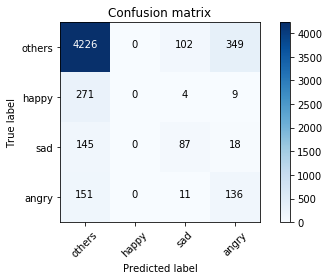

In [26]:
mc_nb = Pipeline([('clf', MultinomialNB())])
mc_nb.fit(emoji_train, y_train)
print_metrics(mc_nb.predict(emoji_test))

/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

     others       0.85      1.00      0.92      4677
      happy       0.00      0.00      0.00       284
        sad       0.00      0.00      0.00       250
      angry       0.00      0.00      0.00       298

avg / total       0.72      0.85      0.78      5509

Accuracy: 0.8489744055182429
Precision: 0.21224360137956072
Recall: 0.25
F1 score:  0.22957981543294717
Confusion matrix, without normalization
[[4677    0    0    0]
 [ 284    0    0    0]
 [ 250    0    0    0]
 [ 298    0    0    0]]


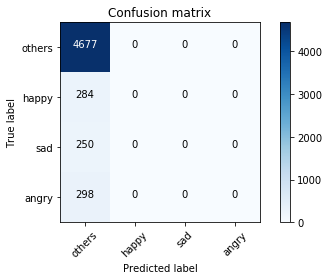

In [27]:
mc_nb.fit(emoji_all, y)
print_metrics(mc_nb.predict(emoji_test))

### SVM - One vs One

             precision    recall  f1-score   support

     others       0.93      0.71      0.80      4677
      happy       0.18      0.48      0.26       284
        sad       0.31      0.62      0.41       250
      angry       0.32      0.72      0.44       298

avg / total       0.83      0.69      0.74      5509

Accuracy: 0.6912325285895807
Precision: 0.43205128611822624
Recall: 0.6306429216607314
F1 score:  0.47764099484047173
Confusion matrix, without normalization
[[3303  620  324  430]
 [ 131  136    6   11]
 [  69    7  154   20]
 [  59    4   20  215]]


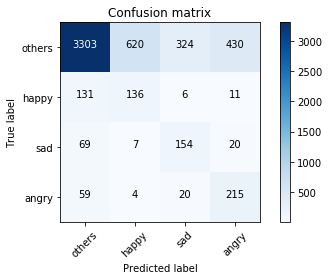

In [28]:
mc_svm_ovo = svm.SVC(decision_function_shape='ovo', kernel='linear', C=100)

mc_svm_ovo.fit(emoji_train, y_train)
print_metrics(mc_svm_ovo.predict(emoji_test))

             precision    recall  f1-score   support

     others       0.91      0.90      0.91      4677
      happy       0.40      0.24      0.30       284
        sad       0.44      0.49      0.46       250
      angry       0.43      0.59      0.50       298

avg / total       0.83      0.83      0.83      5509

Accuracy: 0.8330005445634416
Precision: 0.5431721760818862
Recall: 0.5560692972973453
F1 score:  0.5415139864008913
Confusion matrix, without normalization
[[4222  100  143  212]
 [ 206   69    2    7]
 [ 111    3  122   14]
 [ 108    2   12  176]]


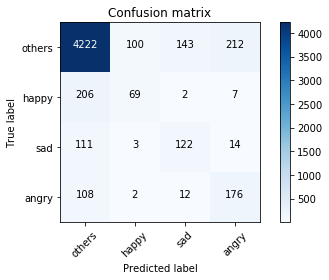

In [29]:
mc_svm_ovo.fit(emoji_all, y)
print_metrics(mc_svm_ovo.predict(emoji_test))

### SVM One vs Rest

             precision    recall  f1-score   support

     others       0.93      0.71      0.80      4677
      happy       0.18      0.48      0.26       284
        sad       0.31      0.62      0.41       250
      angry       0.32      0.72      0.44       298

avg / total       0.83      0.69      0.74      5509

Accuracy: 0.6912325285895807
Precision: 0.43205128611822624
Recall: 0.6306429216607314
F1 score:  0.47764099484047173
Confusion matrix, without normalization
[[3303  620  324  430]
 [ 131  136    6   11]
 [  69    7  154   20]
 [  59    4   20  215]]


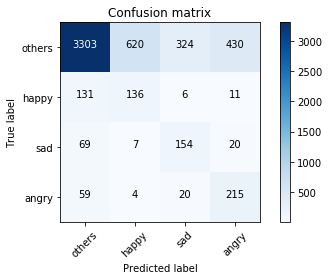

In [30]:
mc_svm_ovr = svm.SVC(decision_function_shape='ovr', kernel='linear', C=100)
mc_svm_ovr.fit(emoji_train, y_train)
print_metrics(mc_svm_ovr.predict(emoji_test))

             precision    recall  f1-score   support

     others       0.91      0.90      0.91      4677
      happy       0.40      0.24      0.30       284
        sad       0.44      0.49      0.46       250
      angry       0.43      0.59      0.50       298

avg / total       0.83      0.83      0.83      5509

Accuracy: 0.8330005445634416
Precision: 0.5431721760818862
Recall: 0.5560692972973453
F1 score:  0.5415139864008913
Confusion matrix, without normalization
[[4222  100  143  212]
 [ 206   69    2    7]
 [ 111    3  122   14]
 [ 108    2   12  176]]


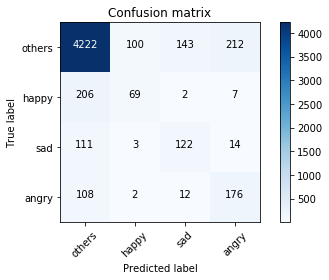

In [31]:
mc_svm_ovr.fit(emoji_all, y)
print_metrics(mc_svm_ovr.predict(emoji_test))